# Statistics Visualization for Species Identifier

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from PIL import Image
import os

In [2]:
csv_file = "../test_dataset/species_identifier/predictions/filtered_pred_annots_yolov10l_bioCLIP_predictions.csv"

labels = {
    0: "grevy's zebra",
    1: "plains zebra",
    2: "neither"
}

df = pd.read_csv(csv_file)

df['species_true_class'] = df['species_true_simple'].astype(int).apply(lambda x: list(labels.values())[x])
df['species_pred_class'] = df['species_pred_simple'].astype(int).apply(lambda x: list(labels.values())[x])

total = len(df)

def print_distribution(name, series, total):
    print(f"{name} distribution:")
    counts = series.value_counts()
    for cls in sorted(labels.values()):
        count = counts.get(cls, 0)
        fraction = count / total if total > 0 else 0
        print(f"{cls}: {count} ({fraction:.4f})")

print_distribution("Ground truth", df['species_true_class'], total)
print()
print_distribution("Predictions", df['species_pred_class'], total)


Ground truth distribution:
grevy's zebra: 129 (0.5079)
neither: 117 (0.4606)
plains zebra: 8 (0.0315)

Predictions distribution:
grevy's zebra: 150 (0.5906)
neither: 89 (0.3504)
plains zebra: 15 (0.0591)


In [3]:
def plot_confusion_matrix(prediction_df, labels):

    true_labels = prediction_df["species_true_simple"]
    pred_labels = prediction_df["species_pred_simple"]

    conf_matrix = confusion_matrix(
        true_labels, pred_labels, labels=true_labels.unique()
    )
    conf_matrix_df = pd.DataFrame(
        conf_matrix, index=true_labels.unique(), columns=true_labels.unique()
    )

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average="weighted")
    recall = recall_score(true_labels, pred_labels, average="weighted")
    f1 = f1_score(true_labels, pred_labels, average="weighted")

    class_accuracy = {}
    classes = true_labels.unique()
    for ix in classes:
        correct = conf_matrix_df.loc[ix, ix]
        total = np.sum(conf_matrix_df.loc[ix, :])
        class_accuracy[ix] = correct / total

    print("PERFORMANCE SUMMARY")
    print("=" * 40)
    print(f"Accuracy  : {accuracy:.2f}")
    print(f"Precision : {precision:.2f}")
    print(f"Recall    : {recall:.2f}")
    print(f"F-1 Score : {f1:.2f}")

    print("-" * 40)
    print("\nClass-wise Accuracy:")
    print("-" * 40)
    for ix in classes:
        print(f"Accuracy of {labels[ix]:<20}: {class_accuracy[ix]:.2f}")

    print("\n\nPlotting Confusion Matrix ...")
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()



PERFORMANCE SUMMARY
Accuracy  : 0.88
Precision : 0.91
Recall    : 0.88
F-1 Score : 0.88
----------------------------------------

Class-wise Accuracy:
----------------------------------------
Accuracy of grevy's zebra       : 0.98
Accuracy of neither             : 0.76
Accuracy of plains zebra        : 1.00


Plotting Confusion Matrix ...


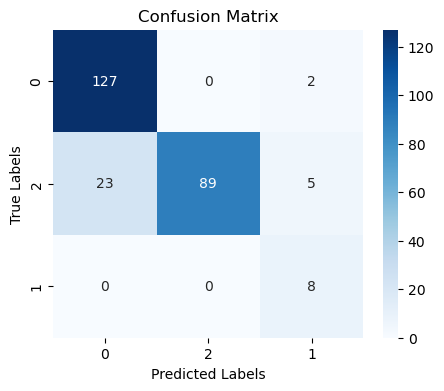

In [4]:
plot_confusion_matrix(df, labels)

# Example Missclassifications

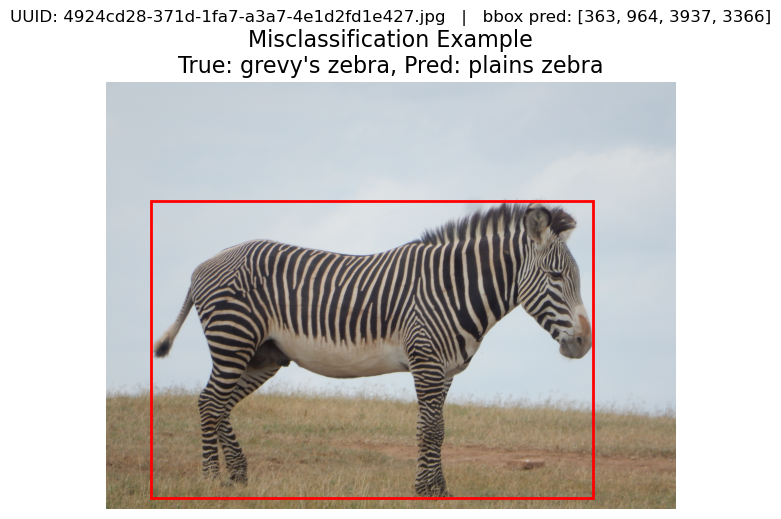

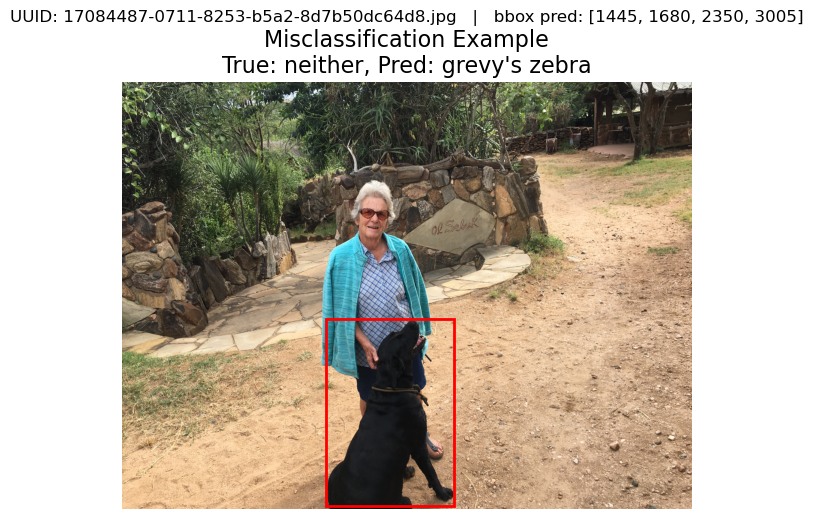

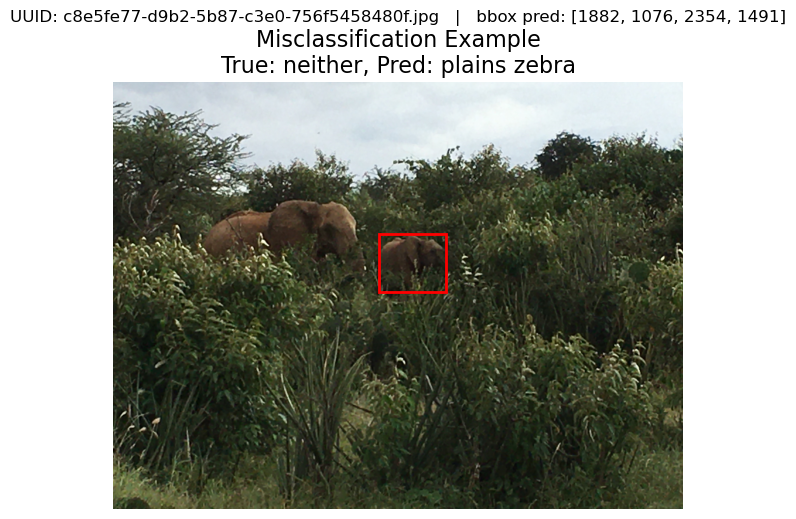

In [ ]:
images_dir = "../test_dataset/images"
misclassified = df[df['species_true_simple'] != df['species_pred_simple']]
mis_groups = misclassified.groupby(['species_true_simple', 'species_pred_simple'])

for (true_label, pred_label), group in mis_groups:
    example = group.sample(n=1).iloc[0]

    img_fname = example['image fname']
    img_path = os.path.join(images_dir, img_fname)

    x = example['bbox x']
    y = example['bbox y']
    w = example['bbox w']
    h = example['bbox h']

    true_class_name = list(labels.values())[int(true_label)]
    pred_class_name = list(labels.values())[int(pred_label)]

    img = Image.open(img_path).convert("RGB")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img)
    
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.set_title(f"Misclassification Example\nTrue: {true_class_name}, Pred: {pred_class_name}", fontsize=16)
    
    fig.suptitle(
        f"Image uuid: { example['image uuid']}   |   bbox pred: {example['bbox pred']}",
        fontsize=12,
        y=0.95
    )
    
    ax.axis('off')

    plt.tight_layout()
    plt.show()
